In [1]:
#https://discuss.analyticsvidhya.com/t/smote-implementation-in-python/19740 

'''
Supervised dimensionality reduction like LDA
80 : 20

AutoEncoder to reduce dimension <- try unsupervised first, can be done supervised
    Try without class labels, then reconstruct with MSPE
    We also want to try with class labels to mantain class seperability (This can be done w/KERAS)
        From the latent code, directly try to force the latent code to be different for different classes
            => can easily be done in Keras with the functional API
    With autoencoder, monitor loss with further split of training into validation
    Use the original data for the AutoEncoder <- don't use SMOTE
SVM is less sensitive to class imbalances            
Additional layer in latent space
Build deep learning classifier with training 80% then use the last layer as the encoding
Use manifold learning
Try different SVM kernels
Stratify k-fold

DWD takes into account other class samples unlike just including support vectors
'''

import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import umap
import seaborn as sns
#from sklearn.model_selection import train_test_split

In [2]:
sa1y = pd.read_csv('sa1y_basc_brief.csv').set_index('norm_id')
sa1y = sa1y[sa1y['AtRisk'] != 0]

In [3]:
twins = sa1y[sa1y['study'] == 'TWIN']
X_train = twins.loc[:, ~sa1y.columns.isin(['AtRisk', 'ROI', 'study'])]
y_train = twins['AtRisk']
y_train.value_counts()

1    129
3     23
2     19
Name: AtRisk, dtype: int64

In [4]:
contes = sa1y[sa1y['study'] == 'CONTE']
X_test = contes.loc[:, ~sa1y.columns.isin(['AtRisk', 'ROI', 'study'])]
y_test = contes['AtRisk']
y_test.value_counts()

1    90
2    25
3    16
Name: AtRisk, dtype: int64

In [5]:
#Smote will oversample the minority classes
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [6]:
X_train_res.shape

(387, 150)

In [7]:
y_train_res.shape

(387,)

In [8]:
Counter(y_train_res)

Counter({1: 129, 3: 129, 2: 129})

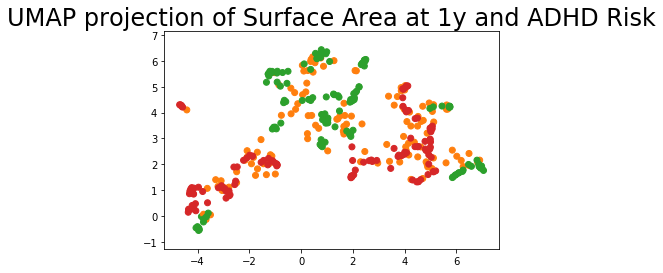

In [9]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_train_res)
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in y_train_res])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of Surface Area at 1y and ADHD Risk', fontsize=24);

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train_res,y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
y_pred=clf.predict(X_test)

In [13]:
Counter(y_pred) 

Counter({1: 131})

In [14]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [15]:
clf = svm.SVC(gamma='scale', decision_function_shape='ovo') # one v. one
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)
Counter(y_pred)

Counter({1: 131})

Confusion matrix, without normalization
[[90  0  0]
 [25  0  0]
 [16  0  0]]


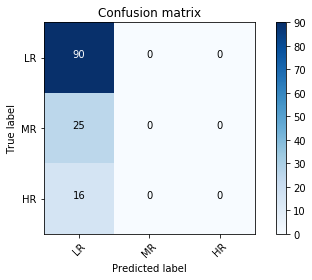

In [16]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['LR','MR','HR'])